In [1]:
from inverseOT import sinkhorn_basic, ma_inverseOT
from plotting import plt_sinkhorn_error as plot_se
import matplotlib.pyplot as plt
import numpy as np
import ot
import ot.plot

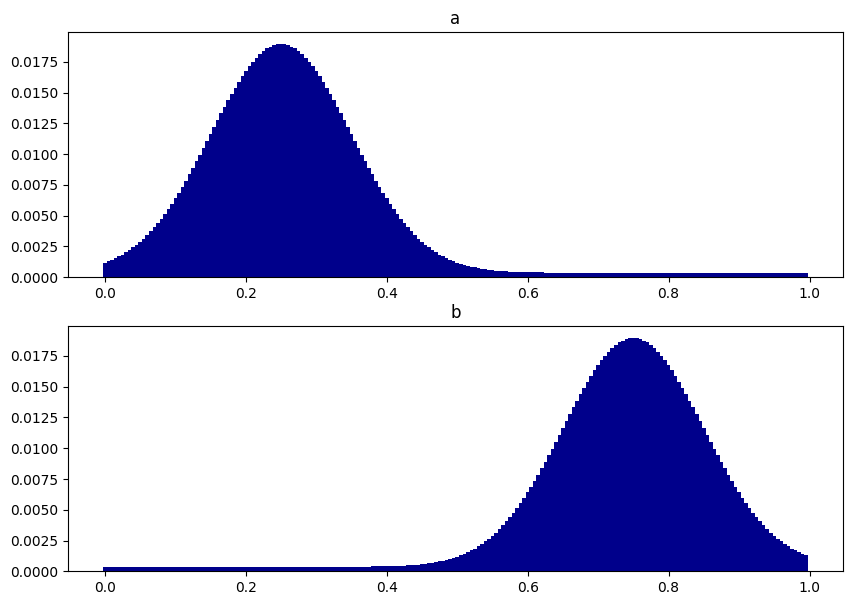

In [2]:
N = 200 # size of histogram
t = np.arange(0, N) / N # histogram bins

Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = 0.1
vmin = 0.02
a = Gaussian(0.25,sigma) # generate histograms
b = Gaussian(0.75,sigma)

a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)

plt.figure(figsize = (10,7)) # plot

plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.title('a')
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")
plt.title('b')

plt.show()

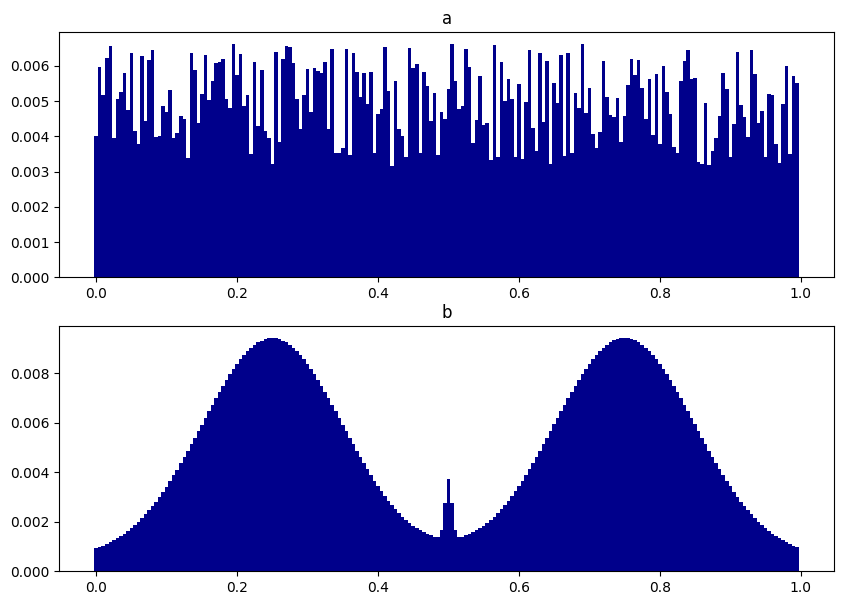

In [3]:
newb = a + b + Gaussian(0.5, 0.005)/200
newb = normalize(newb+np.max(newb)*vmin)

newa = np.random.uniform(0.06,0.13,N)
newa = normalize(newa+np.max(newa)*vmin)

plt.figure(figsize = (10,7)) # plot

plt.subplot(2, 1, 1)
plt.bar(t, newa, width = 1/len(t), color = "darkblue")
plt.title('a')
plt.subplot(2, 1, 2)
plt.bar(t, newb, width = 1/len(t), color = "darkblue")
plt.title('b')

plt.show()

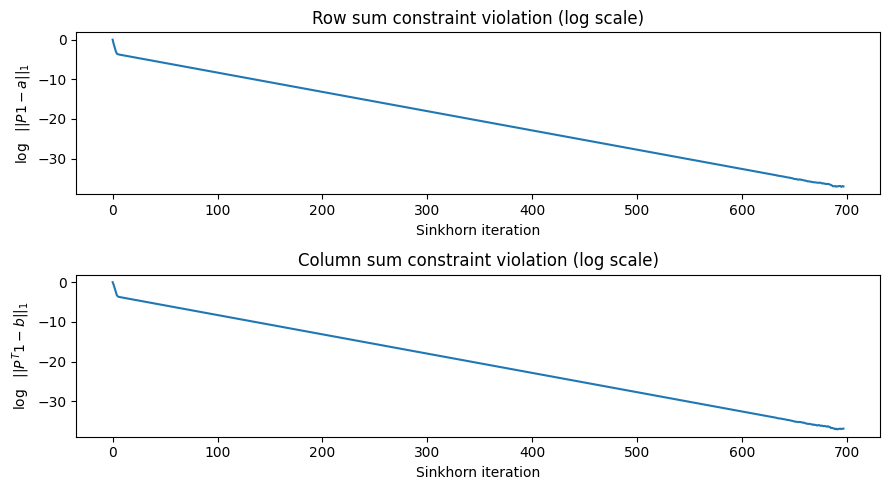

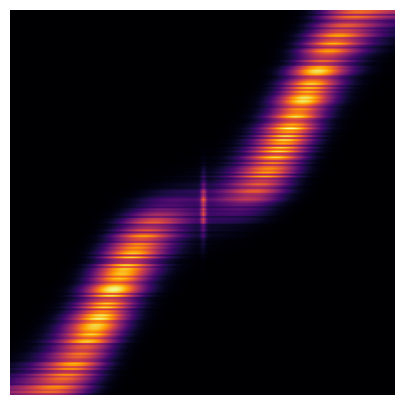

In [23]:
epsilon = 0.0000001
epsilon = 0.01

[Y,X] = np.meshgrid(t,t)

# cost matrix and Gibb's kernel
C = (X-Y)**2
#C = (X-Y)**8
K = np.exp(-C/epsilon)

u, v, errs = sinkhorn_basic(newa, newb, K, max_iter = 10000)
P = np.dot(np.dot(np.diag(u),K),np.diag(v)) # optimal transport plan

plot_se(errs,P)

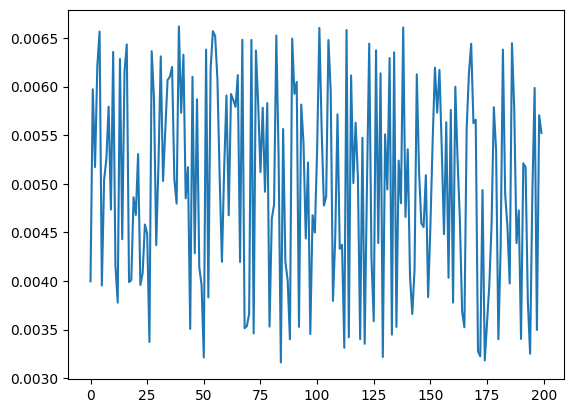

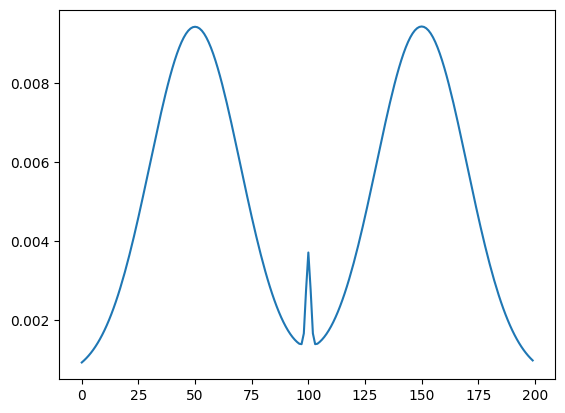

In [5]:
ones = np.ones(N)
plt.plot(np.dot(P,ones))
plt.show()
plt.plot(np.dot(P.T,ones))
plt.show()

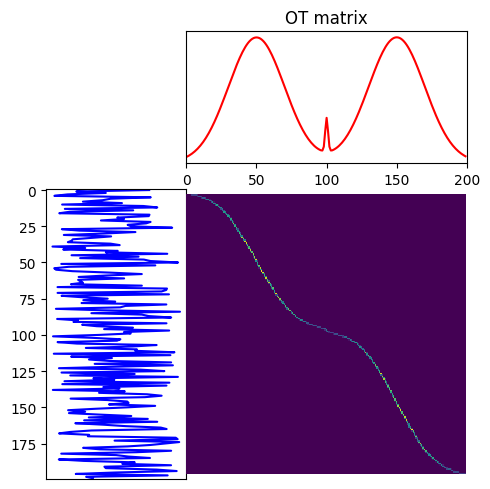

In [6]:
# with exact solver -- no entropic regularisation
# loss matrix
M = ot.dist(t.reshape((N, 1)), t.reshape((N, 1)))
M /= M.max()

G0 = ot.emd(newa, newb, M)

plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(newa, newb, G0, 'OT matrix')

# Inverse OT

In [18]:
def ma_inverseOT2(P, mu, nu, niter = 1000, eps = 0.01, eps_num = 0):
  """
  P is mxn; mu m dim; alpha m dim; vu n dim; beta n dim
  Largely from Ma et al., 2020 (arXiv:2002.09650v2) -- discrete case
  implementation (tangentially) from https://github.com/El-Zag/Inverse-Optimal-Transport/blob/main/2.4%20Learning%20Cost%20Function.ipynb
  """
  m = mu.size
  n = nu.size
  cost = np.random.random((m, n)) #initialisation -- random weights
  alpha = mu
  beta = nu
  u = np.exp(alpha/eps)
  v = np.exp(beta/eps)
  for it in range(niter):
    K=np.exp(-cost/eps)
    u=mu/(np.dot(K,v) + eps_num)
    v=nu/(np.dot(K.T,u) + eps_num)
    K=P/(np.outer(u,v.T) + eps_num)
    cost=-eps*np.log(K+eps_num)
    # optional regularization
    if n == m:
      cost = (cost + cost.T)/2
      #np.fill_diagonal(C, 0)
  return cost

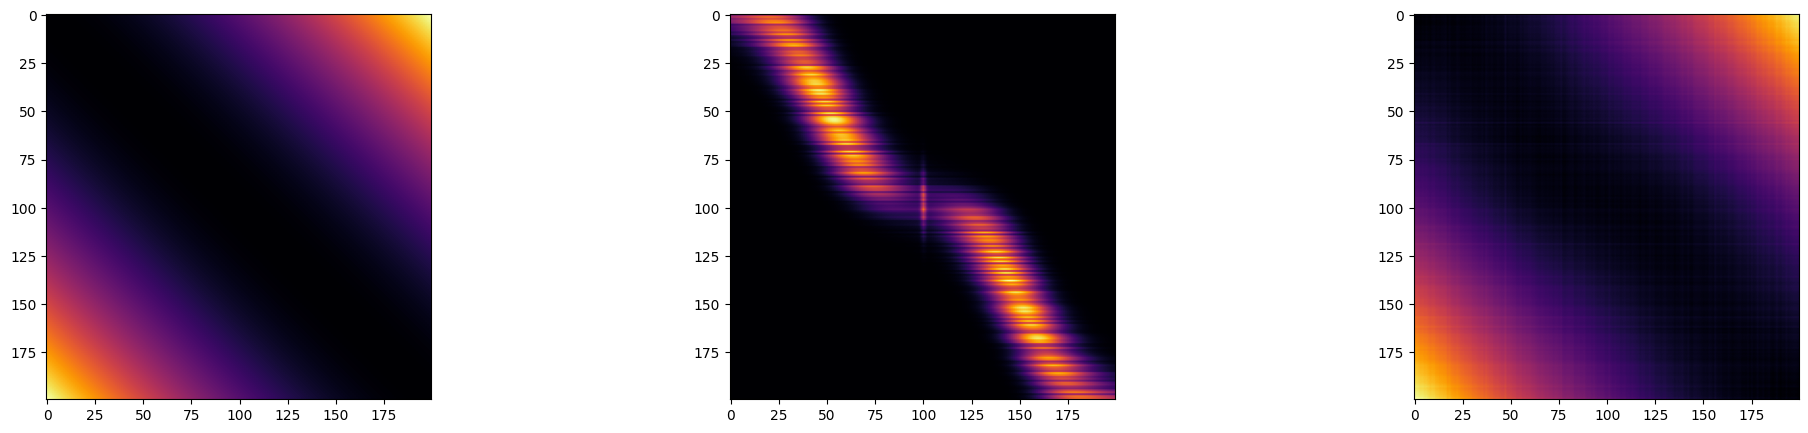

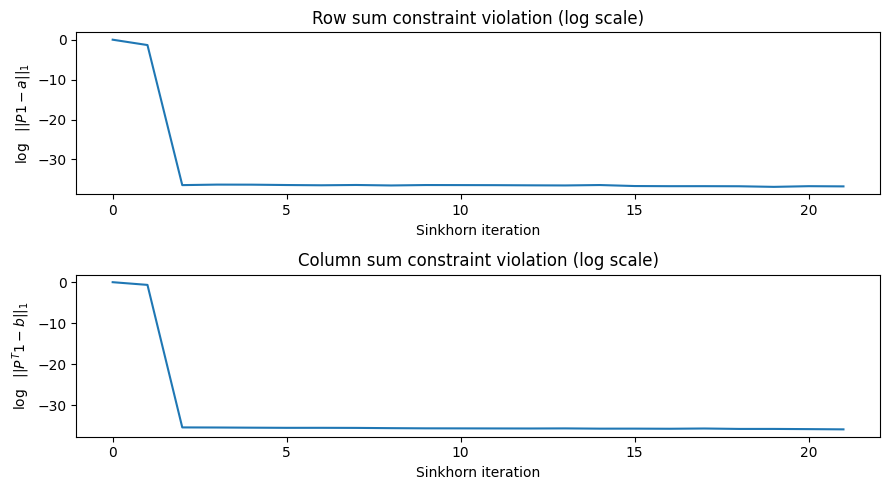

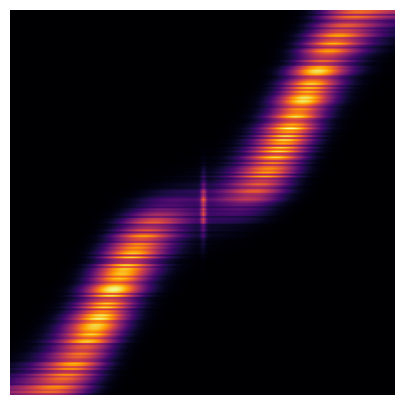

In [27]:
from inverseOT import sinkhorn_single_update
def ma_inverseOT(P, mu, nu, niter = 1000, eps = 0.01, log_err = True):
    """
    P is mxn; mu m dim; alpha m dim; vu n dim; beta n dim
    Largely from Ma et al., 2020 (arXiv:2002.09650v2) -- discrete case
    implementation (tangentially) from https://github.com/El-Zag/Inverse-Optimal-Transport/blob/main/2.4%20Learning%20Cost%20Function.ipynb
    """
    m = mu.size
    n = nu.size
    cost = np.random.random((m, n)) #initialisation -- random weights
    alpha = mu
    beta = nu
    u = np.exp(alpha/eps)
    v = np.exp(beta/eps)
    errs = [(1,1)]
    i = 0
    logsum_err = 0

    while i < niter and logsum_err>-32:
        K=np.exp(-cost/eps)
        u, v, row_err, col_err = sinkhorn_single_update(v, mu, nu, K, log_errs = log_err)
        K=P/(np.outer(u,v.T))
        cost=-eps*np.log(K)
        errs += [(row_err, col_err)]
        logsum_err = np.log(np.sum(errs[-20:-1]))
        i += 1
        # optional regularization
        if n == m:
            #cost = (cost + cost.T)/2
            #np.fill_diagonal(C, 0)
            cost = cost
    return cost, errs

# Parameters
n = 200
m = 200

# assume equal masses
eps = epsilon = 0.01
n_iter = 5000
transport = P
mu, nu = newa, newb
eps = 0.01 # eps doesn't matter!

C_paper,errs = ma_inverseOT(transport, mu, nu, n_iter, eps)
#C_paper = (np.max(C) / np.max(C_paper)) * C_paper

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,5))
ax1.imshow(C, cmap="inferno")
ax2.imshow(P, cmap="inferno")
ax3.imshow(C_paper, cmap="inferno")

plot_se(errs,transport)

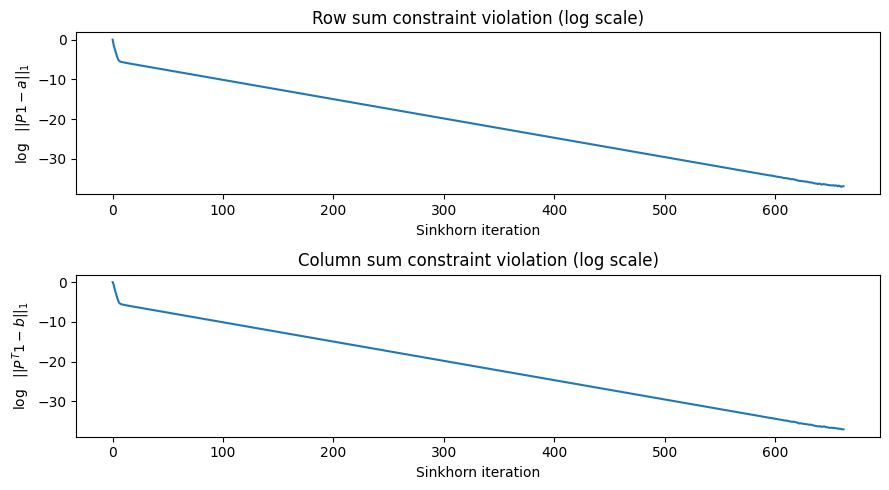

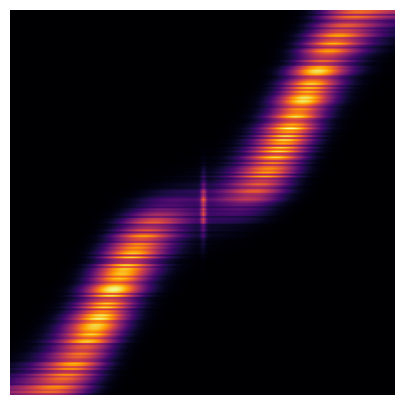

In [28]:
Kpap = np.exp(-C_paper/eps)
upap, vpap, errspap = sinkhorn_basic(newa, newb, Kpap, max_iter = 10000)
Ppap = np.dot(np.dot(np.diag(upap),Kpap),np.diag(vpap))

plot_se(errspap,Ppap)